# Importing Libraries  

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from lightfm import LightFM
from surprise import Reader, Dataset, SVD
from tensorflow.keras.layers import Embedding, Input, Concatenate, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# # Replace the deprecated method with the new one
# tf.losses.sparse_softmax_cross_entropy  # Deprecated
# tf.compat.v1.losses.sparse_softmax_cross_entropy  # New

# # To suppress the warning, you can use the following line
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

C:\Users\shane\anaconda3\Lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


# Data Processing & Displaying

In [2]:
# Load the dataset
movies = pd.read_csv('Untitled Folder/movies.csv', encoding='latin-1')
ratings = pd.read_csv('Untitled Folder/Ratings.csv', encoding='latin-1')
tags = pd.read_csv('Untitled Folder/Tags.csv', encoding='latin-1')

In [3]:
# Display the first few rows of each dataframe
print("Movies DataFrame:")
print(movies.head())

print("\nRatings DataFrame:")
print(ratings.head())

print("\nTags DataFrame:")
print(tags.head())

Movies DataFrame:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings DataFrame:
   userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580

Tags DataFrame:
   userId  movieId            tag   timestamp
0      18     4141    Mark Waters  1240597180
1      65      208      

In [4]:
# Display the shapes of each dataframe
print("Movies DataFrame Shape:", movies.shape)
print("Ratings DataFrame Shape:", ratings.shape)
print("Tags DataFrame Shape:", tags.shape)

Movies DataFrame Shape: (27278, 3)
Ratings DataFrame Shape: (20000263, 4)
Tags DataFrame Shape: (465564, 4)


In [5]:
from sklearn.model_selection import train_test_split

# Assuming 'ratings' is your original DataFrame containing all the ratings
ratings_train, ratings_test = train_test_split(ratings, test_size=0.2, random_state=42)

# Print the shapes of training and testing sets
print("Training Set Shape:", ratings_train.shape)
print("Testing Set Shape:", ratings_test.shape)

Training Set Shape: (16000210, 4)
Testing Set Shape: (4000053, 4)


In [6]:
# Sample 6% of the data
sampled_ratings = ratings.sample(frac=0.06, random_state=42)

In [7]:
sampled_movies = movies.sample(frac=0.06, random_state=42)
sampled_tags = tags.sample(frac=0.06, random_state=42)

In [8]:
n_users = sampled_ratings.userId.unique().shape[0]
n_users

129171

In [9]:
n_items = sampled_ratings.movieId.unique().shape[0]
n_items

15994

# Create a User-Item Matrix

In [10]:
# Create User-Movie matrix 
user_movie_matrix = sampled_ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [11]:
user_movie_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,130374,130502,130512,130970,131019,131025,131092,131100,131142,131258
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Content Filtering

In [12]:
# Content Filtering: Create metadata by merging movies and tags
tags['tag'] = tags['tag'].astype(str)  # Convert 'tag' column to string type
movie_tags = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
metadata = pd.merge(movies, movie_tags, on='movieId', how='left').fillna('')

In [13]:
# Content Filtering: Create metadata by merging sampled_movies and sampled_tags
sampled_tags['tag'] = sampled_tags['tag'].astype(str)  # Convert 'tag' column to string type
sampled_movie_tags = sampled_tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
sampled_metadata = pd.merge(sampled_movies, sampled_movie_tags, on='movieId', how='left').fillna('')

In [14]:
metadata

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Watched computer animation Disney animated fea...
1,2,Jumanji (1995),Adventure|Children|Fantasy,time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),Comedy|Romance,old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Comedy,Diane Keaton family sequel Steve Martin weddin...
...,...,...,...,...
27273,131254,Kein Bund fÃ¼r's Leben (2007),Comedy,
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,
27275,131258,The Pirates (2014),Adventure,bandits Korea mutiny pirates whale
27276,131260,Rentun Ruusu (2001),(no genres listed),


In [15]:
sampled_metadata

,movieId,title,genres,tag
0,61116,Black Caesar (1973),Crime|Drama,blaxploitation
1,70697,G-Force (2009),Action|Adventure|Children|Fantasy,
2,111931,Raze (2013),Action|Horror,
3,26630,Moonwalker (1988),Musical,
4,63692,Don Q Son of Zorro (1925),Adventure|Romance,
...,...,...,...,...
1632,85547,"Hugh Hefner: Playboy, Activist and Rebel (2009)",Documentary,history sexuality
1633,113778,Cat Run 2 (2014),Action,
1634,27357,Old Men in New Cars (Gamle mÃ¦nd i nye biler) ...,Action|Comedy,
1635,6227,Loving You (1957),Drama|Musical,


# TF-IDF Vectorizer on Metadata

In [16]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(metadata['tag'])

print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (27278, 23714)


In [17]:
#TruncatedSVD for Content Filtering
svd_model = TruncatedSVD(n_components=100)
latent_matrix_1 = svd_model.fit_transform(tfidf_matrix)

In [18]:
# Assuming movies DataFrame has a 'title' column
latent_matrix_1_df = pd.DataFrame(latent_matrix_1, index=movies['title'])

# Display the first few rows
print(latent_matrix_1_df.head())

                                          0         1         2         3   \
title                                                                        
Toy Story (1995)                    0.009972  0.007062  0.028378  0.035047   
Jumanji (1995)                      0.006696  0.009372  0.029760  0.030609   
Grumpier Old Men (1995)             0.004407  0.005996  0.015540  0.009667   
Waiting to Exhale (1995)            0.007035  0.008804  0.027061  0.005943   
Father of the Bride Part II (1995)  0.006463  0.011763  0.027828  0.018460   

                                          4         5         6         7   \
title                                                                        
Toy Story (1995)                    0.004573  0.066880 -0.071686 -0.001059   
Jumanji (1995)                      0.006142  0.091382 -0.101545 -0.006378   
Grumpier Old Men (1995)             0.003242  0.034927 -0.021431  0.068332   
Waiting to Exhale (1995)            0.005261  0.046895 -0.03570

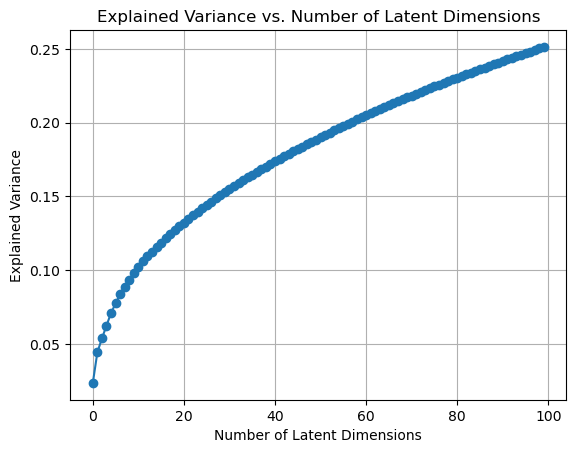

In [19]:
# Plot explained variance for each latent dimension
explained_variance = np.cumsum(svd_model.explained_variance_ratio_)
plt.plot(explained_variance, marker='o')
plt.xlabel('Number of Latent Dimensions')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Latent Dimensions')
plt.grid(True)
plt.show()

TF-IDF Matrix Shape (Sampled): (1637, 1267)
                                     0             1         2         3   \
title                                                                       
Black Caesar (1973)       -1.185431e-08 -9.706360e-07  0.000016  0.000021   
G-Force (2009)             0.000000e+00  0.000000e+00  0.000000  0.000000   
Raze (2013)                0.000000e+00  0.000000e+00  0.000000  0.000000   
Moonwalker (1988)          0.000000e+00  0.000000e+00  0.000000  0.000000   
Don Q Son of Zorro (1925)  0.000000e+00  0.000000e+00  0.000000  0.000000   

                                 4         5         6         7         8   \
title                                                                         
Black Caesar (1973)        0.000005 -0.000003 -0.000028 -0.000013  0.000006   
G-Force (2009)             0.000000  0.000000  0.000000  0.000000  0.000000   
Raze (2013)                0.000000  0.000000  0.000000  0.000000  0.000000   
Moonwalker (1988)    

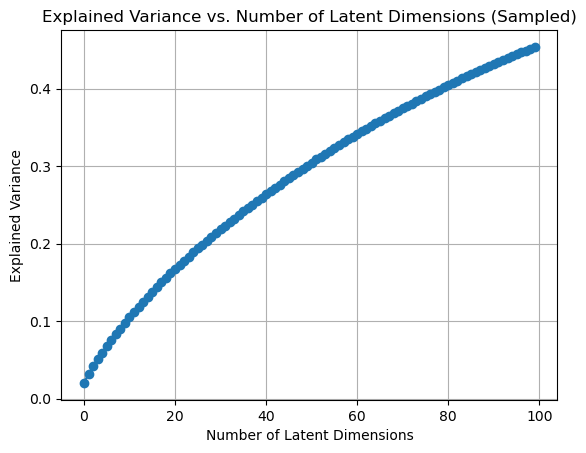

In [20]:
# TF-IDF Vectorizer for Sampled Data
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_sampled = tfidf_vectorizer.fit_transform(sampled_metadata['tag'])

print("TF-IDF Matrix Shape (Sampled):", tfidf_matrix_sampled.shape)

# TruncatedSVD for Content Filtering on Sampled Data
svd_model_sampled = TruncatedSVD(n_components=100)
latent_matrix_1_sampled = svd_model_sampled.fit_transform(tfidf_matrix_sampled)

# Assuming sampled_movies DataFrame has a 'title' column
latent_matrix_1_df_sampled = pd.DataFrame(latent_matrix_1_sampled, index=sampled_movies['title'])

# Display the first few rows
print(latent_matrix_1_df_sampled.head())

# Plot explained variance for each latent dimension
explained_variance_sampled = np.cumsum(svd_model_sampled.explained_variance_ratio_)
plt.plot(explained_variance_sampled, marker='o')
plt.xlabel('Number of Latent Dimensions')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Latent Dimensions (Sampled)')
plt.grid(True)
plt.show()

# Collaborative Filtering

In [21]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(user_movie_matrix)

In [22]:
# Assuming latent_matrix_2 is a NumPy array
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=user_movie_matrix.index)

# Display the first few rows
print(latent_matrix_2_df.head())

             0         1         2         3         4         5         6    \
userId                                                                         
1       1.623335 -0.343817 -0.309998 -0.352248 -0.182370 -0.223923 -0.184563   
2       0.051713 -0.011224 -0.008569 -0.011754 -0.004125 -0.007479 -0.007601   
3       0.889431 -0.218256 -0.208246 -0.140004 -0.089899 -0.111345 -0.031467   
4       0.282918  0.017219  0.025912  0.068471  0.047990 -0.017833  0.147905   
5       0.795906  0.153565  0.290435  0.479579  0.265082 -0.091465  0.886833   

             7         8         9    ...       190       191       192  \
userId                                ...                                 
1       0.024608 -0.290366  0.042713  ... -0.065490 -0.336066  0.294259   
2      -0.012516 -0.008827 -0.008107  ... -0.006221 -0.024576  0.022986   
3      -0.156540 -0.211511 -0.103668  ...  0.292689  0.287326 -0.211439   
4      -0.180568  0.139556 -0.098936  ...  0.139442 -0.171144 -0

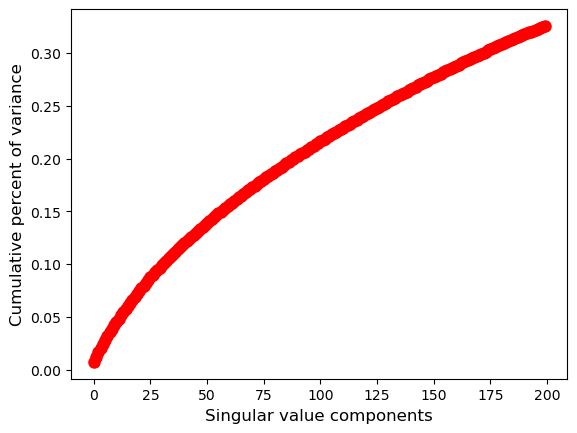

In [23]:
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [24]:
# Assuming latent_matrix_2 is a NumPy array
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=user_movie_matrix.index)

# Assuming movies have a 'title' column
movies_with_titles = movies[['movieId', 'title']]

# Merge the latent_matrix_2_df with movies_with_titles
latent_matrix_2_df = pd.merge(latent_matrix_2_df, movies_with_titles, left_index=True, right_on='movieId')

# Set the 'title' column as the index
latent_matrix_2_df.set_index('title', inplace=True)

# Drop the 'movieId' column after setting the index
latent_matrix_2_df.drop('movieId', axis=1, inplace=True)

# Display the first few rows
print(latent_matrix_2_df.head())

                                         0         1         2         3    \
title                                                                        
Toy Story (1995)                    1.623335 -0.343817 -0.309998 -0.352248   
Jumanji (1995)                      0.051713 -0.011224 -0.008569 -0.011754   
Grumpier Old Men (1995)             0.889431 -0.218256 -0.208246 -0.140004   
Waiting to Exhale (1995)            0.282918  0.017219  0.025912  0.068471   
Father of the Bride Part II (1995)  0.795906  0.153565  0.290435  0.479579   

                                         4         5         6         7    \
title                                                                        
Toy Story (1995)                   -0.182370 -0.223923 -0.184563  0.024608   
Jumanji (1995)                     -0.004125 -0.007479 -0.007601 -0.012516   
Grumpier Old Men (1995)            -0.089899 -0.111345 -0.031467 -0.156540   
Waiting to Exhale (1995)            0.047990 -0.017833  0.14790

# Recommendation System with Hybrid Recommedation 

In [25]:
common_indices = latent_matrix_1_df_sampled.index.intersection(latent_matrix_2_df.index)

In [26]:
# Select a movie title from the index
selected_movie_title = 'Black Caesar (1973)'

# Extract the latent vector for the selected movie from both content and collaborative matrices
content_latent_vector = latent_matrix_1_df_sampled.loc[selected_movie_title].values.reshape(1, -1)
collaborative_latent_vector = latent_matrix_2_df.loc[selected_movie_title].values.reshape(1, -1)

# Calculate cosine similarity
similarity_score_content = cosine_similarity(latent_matrix_1_df_sampled, content_latent_vector).reshape(-1)
similarity_score_collaborative = cosine_similarity(latent_matrix_2_df, collaborative_latent_vector).reshape(-1)

In [27]:
# Convert indices to integer locations
common_indices_loc = [latent_matrix_1_df_sampled.index.get_loc(idx) for idx in common_indices]

# Take a subset of similarity_score_content and similarity_score_collaborative using common indices
subset_similarity_score_content = similarity_score_content[common_indices_loc]
subset_similarity_score_collaborative = similarity_score_collaborative[common_indices_loc]

# An average measure of both content and collaborative
hybrid = ((subset_similarity_score_content + subset_similarity_score_collaborative) / 2.0)

# Form a DataFrame of similar movies
dict_df = {'content': subset_similarity_score_content, 'collaborative': subset_similarity_score_collaborative, 'hybrid': hybrid}
similar = pd.DataFrame(dict_df, index=common_indices)

# Sort it on the basis of either: content, collaborative, or hybrid, here: content
similar.sort_values('content', ascending=False, inplace=True)

print(similar[1:].head(11))

                                                     content  collaborative  \
title                                                                         
Undercover Brother (2002)                           1.000000      -0.002556   
Pale Rider (1985)                                   0.039522      -0.004199   
K-19: The Widowmaker (2002)                         0.038387       0.008863   
Mea Maxima Culpa: Silence in the House of God (...  0.036805      -0.029161   
Don't Tempt Me (Sin noticias de Dios) (2001)        0.030675       0.004528   
Chungking Express (Chung Hing sam lam) (1994)       0.030513      -0.003367   
Clone (Womb) (2010)                                 0.030274       0.304135   
Bat Whispers, The (1930)                            0.022501       0.033627   
Book of Life, The (2014)                            0.021841      -0.003766   
Standard Operating Procedure (2008)                 0.020847       0.005564   
MacGyver: Lost Treasure of Atlantis (1994)          

In [28]:
print(latent_matrix_1_df_sampled.index)

Index(['Black Caesar (1973)', 'G-Force (2009)', 'Raze (2013)',
       'Moonwalker (1988)', 'Don Q Son of Zorro (1925)', 'Chaos (2005)',
       'Devil's Own, The (1997)', 'Other Man, The (2008)', 'Descent (2007)',
       'Royal Scandal, The (2001)',
       ...
       'Weight of the Nation (2012)', 'Miracle on 34th Street (1994)',
       'Three Wishes (1995)', 'Metropia (2009)',
       'Older Brother, Younger Sister (Ani imÃ´to) (1953)',
       'Hugh Hefner: Playboy, Activist and Rebel (2009)', 'Cat Run 2 (2014)',
       'Old Men in New Cars (Gamle mÃ¦nd i nye biler) (2002)',
       'Loving You (1957)', 'Prophecy (1979)'],
      dtype='object', name='title', length=1637)


In [29]:
print(latent_matrix_2_df.index)

Index(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)',
       'Heat (1995)', 'Sabrina (1995)', 'Tom and Huck (1995)',
       'Sudden Death (1995)', 'GoldenEye (1995)',
       ...
       'Three Quarter Moon (2011)', 'Ants in the Pants (2000)',
       'Werner - Gekotzt wird spÃ¤ter (2003)', 'Brother Bear 2 (2006)',
       'Forklift Driver Klaus: The First Day on the Job (2001)',
       'Kein Bund fÃ¼r's Leben (2007)', 'Feuer, Eis & Dosenbier (2002)',
       'The Pirates (2014)', 'Rentun Ruusu (2001)', 'Innocence (2014)'],
      dtype='object', name='title', length=25510)


In [30]:
common_indices = latent_matrix_1_df_sampled.index.intersection(latent_matrix_2_df.index)

# Select a movie title from the index
selected_movie_title = 'Hugh Hefner: Playboy, Activist and Rebel (2009)'

# Extract the latent vector for the selected movie from both content and collaborative matrices
content_latent_vector = latent_matrix_1_df_sampled.loc[selected_movie_title].values.reshape(1, -1)
collaborative_latent_vector = latent_matrix_2_df.loc[selected_movie_title].values.reshape(1, -1)

# Calculate cosine similarity
similarity_score_content = cosine_similarity(latent_matrix_1_df_sampled, content_latent_vector).reshape(-1)
similarity_score_collaborative = cosine_similarity(latent_matrix_2_df, collaborative_latent_vector).reshape(-1)

# Convert indices to integer locations
common_indices_loc = [latent_matrix_1_df_sampled.index.get_loc(idx) for idx in common_indices]

# Take a subset of similarity_score_content and similarity_score_collaborative using common indices
subset_similarity_score_content = similarity_score_content[common_indices_loc]
subset_similarity_score_collaborative = similarity_score_collaborative[common_indices_loc]

# An average measure of both content and collaborative
hybrid = ((subset_similarity_score_content + subset_similarity_score_collaborative) / 2.0)

# Form a DataFrame of similar movies
dict_df = {'content': subset_similarity_score_content, 'collaborative': subset_similarity_score_collaborative, 'hybrid': hybrid}
similar = pd.DataFrame(dict_df, index=common_indices)

# Sort it on the basis of either: content, collaborative, or hybrid, here: content
similar.sort_values('content', ascending=False, inplace=True)

print(similar[1:].head(11))

                                                     content  collaborative  \
title                                                                         
Last Days in Vietnam (2014)                         0.979371       0.026638   
Howard Zinn: You Can't Be Neutral on a Moving T...  0.688449       0.014943   
Memoirs of a Geisha (2005)                          0.645732       0.000112   
Good Night, and Good Luck. (2005)                   0.458806       0.012631   
Apocalypto (2006)                                   0.372916      -0.006278   
Piano, The (1993)                                   0.272183       0.023817   
Intouchables (2011)                                 0.189833      -0.000428   
American Beauty (1999)                              0.189383       0.001827   
Hotel Rwanda (2004)                                 0.186313      -0.000981   
Titanic (1997)                                      0.159006      -0.001605   
Vicky Cristina Barcelona (2008)                     

In [31]:
def recommend_similar_movies(title):

    # Extract the latent vector for the selected movie from both content and collaborative matrices
    content_latent_vector = latent_matrix_1_df_sampled.loc[selected_movie_title].values.reshape(1, -1)
    collaborative_latent_vector = latent_matrix_2_df.loc[selected_movie_title].values.reshape(1, -1)

    # Calculate cosine similarity
    similarity_score_content = cosine_similarity(latent_matrix_1_df_sampled, content_latent_vector).reshape(-1)
    similarity_score_collaborative = cosine_similarity(latent_matrix_2_df, collaborative_latent_vector).reshape(-1)

    # Convert indices to integer locations
    common_indices_loc = [latent_matrix_1_df_sampled.index.get_loc(idx) for idx in common_indices]

    # Take a subset of similarity_score_content and similarity_score_collaborative using common indices
    subset_similarity_score_content = similarity_score_content[common_indices_loc]
    subset_similarity_score_collaborative = similarity_score_collaborative[common_indices_loc]

    # An average measure of both content and collaborative
    hybrid = ((subset_similarity_score_content + subset_similarity_score_collaborative) / 2.0)

    # Form a DataFrame of similar movies
    dict_df = {'content': subset_similarity_score_content, 'collaborative': subset_similarity_score_collaborative, 'hybrid': hybrid}
    similar = pd.DataFrame(dict_df, index=common_indices)

    # Sort it on the basis of either: content, collaborative, or hybrid, here: content
    similar.sort_values('content', ascending=False, inplace=True)

    print(similar[1:].head(11))

In [32]:
recommend_similar_movies("Piano, The (1993)")

                                                     content  collaborative  \
title                                                                         
Last Days in Vietnam (2014)                         0.979371       0.026638   
Howard Zinn: You Can't Be Neutral on a Moving T...  0.688449       0.014943   
Memoirs of a Geisha (2005)                          0.645732       0.000112   
Good Night, and Good Luck. (2005)                   0.458806       0.012631   
Apocalypto (2006)                                   0.372916      -0.006278   
Piano, The (1993)                                   0.272183       0.023817   
Intouchables (2011)                                 0.189833      -0.000428   
American Beauty (1999)                              0.189383       0.001827   
Hotel Rwanda (2004)                                 0.186313      -0.000981   
Titanic (1997)                                      0.159006      -0.001605   
Vicky Cristina Barcelona (2008)                     

In [33]:
recommend_similar_movies("Don Q Son of Zorro (1925)")

                                                     content  collaborative  \
title                                                                         
Last Days in Vietnam (2014)                         0.979371       0.026638   
Howard Zinn: You Can't Be Neutral on a Moving T...  0.688449       0.014943   
Memoirs of a Geisha (2005)                          0.645732       0.000112   
Good Night, and Good Luck. (2005)                   0.458806       0.012631   
Apocalypto (2006)                                   0.372916      -0.006278   
Piano, The (1993)                                   0.272183       0.023817   
Intouchables (2011)                                 0.189833      -0.000428   
American Beauty (1999)                              0.189383       0.001827   
Hotel Rwanda (2004)                                 0.186313      -0.000981   
Titanic (1997)                                      0.159006      -0.001605   
Vicky Cristina Barcelona (2008)                     

In [34]:
recommend_similar_movies("Cat Run 2 (2014)")

                                                     content  collaborative  \
title                                                                         
Last Days in Vietnam (2014)                         0.979371       0.026638   
Howard Zinn: You Can't Be Neutral on a Moving T...  0.688449       0.014943   
Memoirs of a Geisha (2005)                          0.645732       0.000112   
Good Night, and Good Luck. (2005)                   0.458806       0.012631   
Apocalypto (2006)                                   0.372916      -0.006278   
Piano, The (1993)                                   0.272183       0.023817   
Intouchables (2011)                                 0.189833      -0.000428   
American Beauty (1999)                              0.189383       0.001827   
Hotel Rwanda (2004)                                 0.186313      -0.000981   
Titanic (1997)                                      0.159006      -0.001605   
Vicky Cristina Barcelona (2008)                     

# Matrix Factorization Recommender

In [35]:
class MF():

    # Initializing the user-movie rating matrix, no. of latent features, alpha and beta.
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    # Initializing user-feature and movie-feature matrix 
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # List of training samples
        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and moive j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [36]:
# Assuming 'sampled_ratings' is your current sampled DataFrame and using 0.5% of data
new_sample = ratings.sample(frac=0.005, random_state=42)

# Display the first few rows of the new sample
print(new_sample.head())

          userId  movieId  rating   timestamp
17679788  122270     8360     3.5  1335056824
7106385    49018       32     2.0  1000194636
12970708   89527   109374     3.5  1420536400
15426752  106704     1060     3.0   948576477
6934678    47791     1732     2.0  1137685703


In [37]:
R= np.array(new_sample.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0))

In [38]:
mf = MF(R, K=20, alpha=0.001, beta=0.01, iterations=100)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()

Iteration: 20 ; error = 298.2029
Iteration: 40 ; error = 284.7366
Iteration: 60 ; error = 274.8523
Iteration: 80 ; error = 266.6547
Iteration: 100 ; error = 259.4114

P x Q:
[[3.92843105 3.28654468 3.28250657 ... 3.5509645  3.57268535 3.63060727]
 [3.98381425 3.39906604 3.32922536 ... 3.60925046 3.62393249 3.71017833]
 [3.94292035 3.34067912 3.29690841 ... 3.60281177 3.58977684 3.67714346]
 ...
 [3.84027662 3.27337012 3.1980275  ... 3.52279587 3.5033983  3.59015229]
 [3.7813611  3.21333805 3.16755501 ... 3.44935783 3.45202816 3.52467392]
 [3.89528417 3.28678881 3.23868195 ... 3.51279378 3.51993843 3.59282556]]



# Surprise

In [39]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [40]:
Mapping_file = dict(zip(metadata.title.tolist(), metadata.movieId.tolist()))

In [41]:
# Assuming 'userId', 'movieId', and 'rating' are your column names
reader = Reader(rating_scale=(0.5, 5.0))  # Adjust the rating scale if needed
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [42]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

In [43]:
model = SVD()  # You can use other algorithms too
model.fit(trainset)

In [44]:
predictions = model.test(testset)

In [45]:
accuracy.rmse(predictions)

RMSE: 0.7894


0.7894175503577701

In [46]:
def pred_user_rating(ui):
    if ui in ratings.userId.unique():
        ui_list = ratings[ratings.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = model.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [47]:
userId = 1
pred_user_rating(userId)

,ratings
movies,
Harry Potter and the Deathly Hallows: Part 2 (2011),4.466989
Harry Potter and the Deathly Hallows: Part 1 (2010),4.462279
Bleak House (2005),4.450101
"Art of Flight, The (2011)",4.446975
The Lunchbox (2013),4.440196
Serenity (2005),4.413307
Zero Motivation (Efes beyahasei enosh) (2014),4.404788
For the Birds (2000),4.399794
Spirited Away (Sen to Chihiro no kamikakushi) (2001),4.391458


In [48]:
pred_user_rating(50)

,ratings
movies,
Frozen Planet (2011),4.961065
Cosmos (1980),4.888655
Presto (2008),4.839488
Play Time (a.k.a. Playtime) (1967),4.781770
Black Mirror (2011),4.768761
Dr. Horrible's Sing-Along Blog (2008),4.762519
Louis C.K.: Shameless (2007),4.728136
"Celebration, The (Festen) (1998)",4.721869
Princess Mononoke (Mononoke-hime) (1997),4.708822


In [49]:
pred_user_rating(49)

,ratings
movies,
"Godfather, The (1972)",4.557698
"Godfather: Part II, The (1974)",4.498296
Star Wars: Episode IV - A New Hope (1977),4.470171
High Plains Drifter (1973),4.422844
Reservoir Dogs (1992),4.416721
"Shawshank Redemption, The (1994)",4.416087
Gladiator (2000),4.401400
Unforgiven (1992),4.385112
Cosmos (1980),4.371682


In [50]:
pred_user_rating(915)

,ratings
movies,
Schindler's List (1993),4.608788
"Lives of Others, The (Das leben der Anderen) (2006)",4.595469
American Beauty (1999),4.518867
"Revolution Will Not Be Televised, The (a.k.a. Chavez: Inside the Coup) (2003)",4.473827
"Postman, The (Postino, Il) (1994)",4.444590
"English Patient, The (1996)",4.422715
Band of Brothers (2001),4.421120
Frozen Planet (2011),4.416773
"Civil War, The (1990)",4.415809


In [51]:
pred_user_rating(100)

,ratings
movies,
"Celebration, The (Festen) (1998)",4.495800
Blue Velvet (1986),4.481534
"Sorrow and the Pity, The (Le chagrin et la pitiÃ©) (1969)",4.477185
This Is Spinal Tap (1984),4.425052
Brazil (1985),4.421160
My Neighbor Totoro (Tonari no Totoro) (1988),4.418334
Taxi Driver (1976),4.417356
Fawlty Towers (1975-1979),4.415939
Mulholland Drive (2001),4.400016


In [52]:
pred_user_rating(1000)

,ratings
movies,
Interstellar (2014),4.935574
Frozen Planet (2011),4.899675
Star Wars: Episode VI - Return of the Jedi (1983),4.889043
Star Wars: Episode IV - A New Hope (1977),4.881261
Star Wars: Episode V - The Empire Strikes Back (1980),4.834680
Battlestar Galactica (2003),4.810213
Black Mirror (2011),4.770764
Edge of Tomorrow (2014),4.759216
Zizek! (2005),4.742423
